<a href="https://colab.research.google.com/github/cdiegor/MineracaoDeDados/blob/main/Pr%C3%A1tica_3_%C3%81rvores_de_Decis%C3%A3o%2C_Florestas_Aleat%C3%B3rias_e_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Laboratório — Árvores de Decisão, Florestas Aleatórias e Boosting
**Tópicos:** Árvores (CART), Random Forests, AdaBoost, Gradient Boosting e HistGradientBoosting.  
**Foco:** comparação de desempenho, hiperparâmetros essenciais, importância de atributos (Gini e permutação), dependência parcial e *learning curves*.

**Datasets:**
- **Classificação** — *Breast Cancer Wisconsin* (binário)
- **Regressão** — *California Housing* (contínuo)

> Objetivo: aplicar e comparar **modelos baseados em árvore**, entendendo *bias–variance*, interpretabilidade e boas práticas de validação.


In [ ]:

# --- Preparação ---------------------------------------------------------------
# !pip install scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    PrecisionRecallDisplay, RocCurveDisplay,
    mean_squared_error, r2_score
)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

np.random.seed(7)
plt.rcParams['figure.figsize'] = (7, 4)


## 1) Carregamento dos dados e *splits*

In [37]:

# Classificação
bc = load_breast_cancer(as_frame=True)
Xc = bc.data.copy()
yc = bc.target.copy()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, stratify=yc, random_state=42
)

# Regressão
house = fetch_california_housing(as_frame=True)
Xr = house.data.copy()
yr = house.target.copy()

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

Xc_train.shape, Xr_train.shape


((455, 30), (16512, 8))


## 2) Árvores de decisão (CART) — Baselines
Vamos começar com **árvores** simples: controlar profundidade, min_samples_leaf e critério (entropia/Gini).


In [39]:

tree_cls = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=7)
tree_reg = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=7)

tree_cls.fit(Xc_train, yc_train)
predc = tree_cls.predict(Xc_test)
acc_tree = accuracy_score(yc_test, predc)
f1_tree = f1_score(yc_test, predc)

tree_reg.fit(Xr_train, yr_train)
predr = tree_reg.predict(Xr_test)
rmse_tree = np.sqrt(mean_squared_error(yr_test, predr))
r2_tree = r2_score(yr_test, predr)

print(f"[Classificação] Árvore: ACC={acc_tree:.3f} | F1={f1_tree:.3f}")
print(f"[Regressão] Árvore: RMSE={rmse_tree:.3f} | R2={r2_tree:.3f}")


[Classificação] Árvore: ACC=0.930 | F1=0.944
[Regressão] Árvore: RMSE=0.724 | R2=0.600


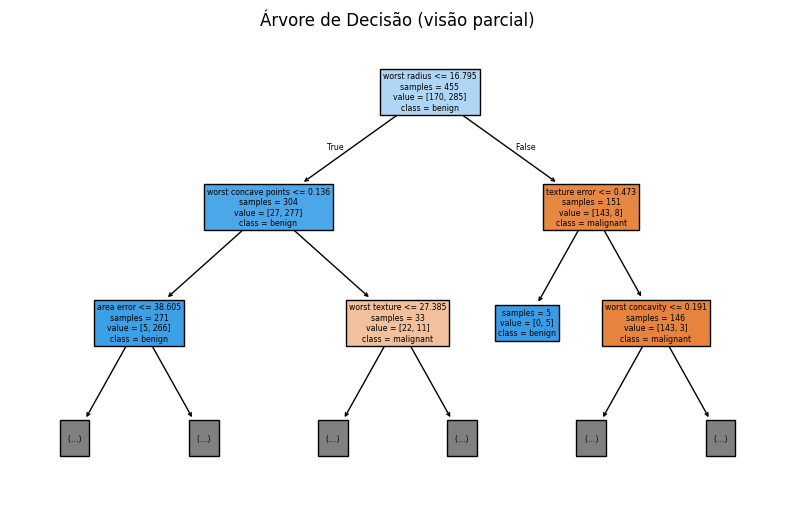

In [40]:

# Visualização parcial da árvore
plt.figure(figsize=(10,6))
plot_tree(tree_cls, feature_names=Xc.columns, class_names=bc.target_names, filled=True, impurity=False, max_depth=2)
plt.title("Árvore de Decisão (visão parcial)")
plt.show()


## 3) Florestas Aleatórias (RF)

In [41]:

rf_cls = RandomForestClassifier(n_estimators=400, max_features='sqrt', oob_score=True, random_state=7, n_jobs=-1)
rf_cls.fit(Xc_train, yc_train)
predc_rf = rf_cls.predict(Xc_test)
acc_rf = accuracy_score(yc_test, predc_rf)
print(f"[Classificação] RF: ACC={acc_rf:.3f} | OOB={rf_cls.oob_score_:.3f}")

rf_reg = RandomForestRegressor(n_estimators=400, max_features='sqrt', random_state=7, n_jobs=-1)
rf_reg.fit(Xr_train, yr_train)
pred_rf = rf_reg.predict(Xr_test)
rmse_rf = np.sqrt(mean_squared_error(yr_test, pred_rf))
r2_rf = r2_score(yr_test, pred_rf)
print(f"[Regressão] RF: RMSE={rmse_rf:.3f} | R2={r2_rf:.3f}")


[Classificação] RF: ACC=0.956 | OOB=0.963
[Regressão] RF: RMSE=0.493 | R2=0.814


### 4) Boosting baseado em árvores — AdaBoost / GradientBoosting / HistGB

In [42]:

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=7),
    n_estimators=300, learning_rate=0.5, random_state=7
)
ada.fit(Xc_train, yc_train)
predc_ada = ada.predict(Xc_test)
acc_ada = accuracy_score(yc_test, predc_ada)
print(f"AdaBoost (stumps) — ACC teste: {acc_ada:.3f}")


AdaBoost (stumps) — ACC teste: 0.965


In [43]:

gbc = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=7
)
gbc.fit(Xc_train, yc_train)
predc_gbc = gbc.predict(Xc_test)
acc_gbc = roc_auc_score(yc_test, predc_gbc)
print(f"GradientBoostingClassifier — ACC teste: {acc_gbc:.3f}")


GradientBoostingClassifier — ACC teste: 0.945


In [44]:

gbr = GradientBoostingRegressor(
    n_estimators=400, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=7
)
gbr.fit(Xr_train, yr_train)
pred_gbr = gbr.predict(Xr_test)
rmse_gbr = np.sqrt(mean_squared_error(yr_test, pred_gbr))
r2_gbr = r2_score(yr_test, pred_gbr)
print(f"GradientBoostingRegressor — RMSE={rmse_gbr:.3f} | R2={r2_gbr:.3f}")


GradientBoostingRegressor — RMSE=0.509 | R2=0.802


In [45]:

hgbc = HistGradientBoostingClassifier(max_depth=None, learning_rate=0.05, max_iter=300, random_state=7)
hgbc.fit(Xc_train, yc_train)
predc_hgbc = hgbc.predict(Xc_test)
acc_hgbc = roc_auc_score(yc_test, predc_hgbc)
print(f"HistGradientBoostingClassifier — ACC teste: {acc_hgbc:.3f}")


HistGradientBoostingClassifier — ACC teste: 0.964


In [46]:

hgbr = HistGradientBoostingRegressor(max_depth=None, learning_rate=0.06, max_iter=400, random_state=7)
hgbr.fit(Xr_train, yr_train)
pred_hgbr = hgbr.predict(Xr_test)
rmse_hgbr = np.sqrt(mean_squared_error(yr_test, pred_hgbr))
r2_hgbr = r2_score(yr_test, pred_hgbr)
print(f"HistGradientBoostingRegressor — RMSE={rmse_hgbr:.3f} | R2={r2_hgbr:.3f}")


HistGradientBoostingRegressor — RMSE=0.450 | R2=0.846


## 5) Métricas e curvas (classificação)

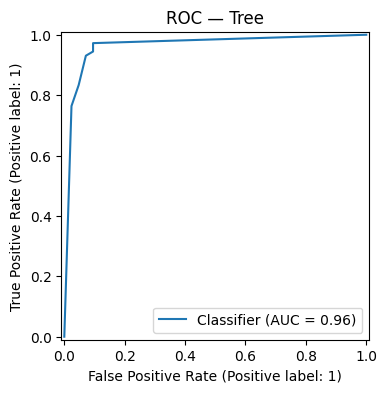

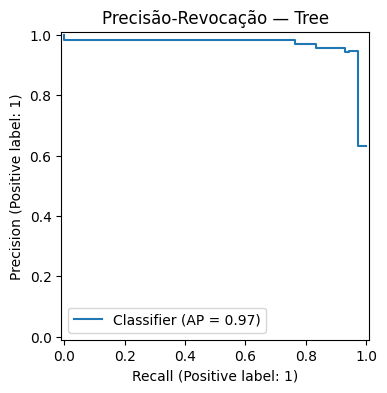

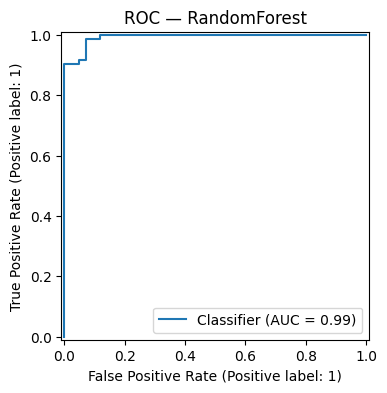

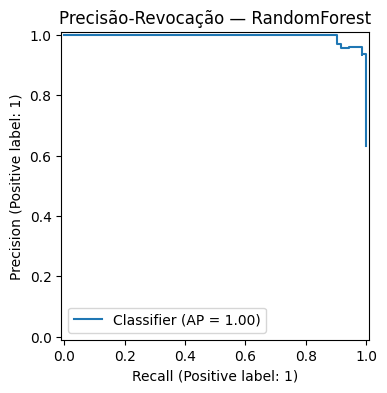

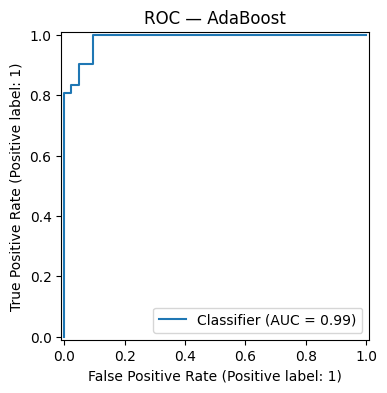

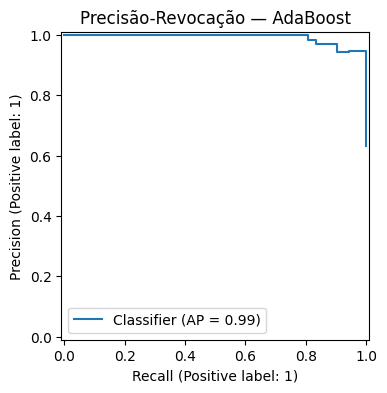

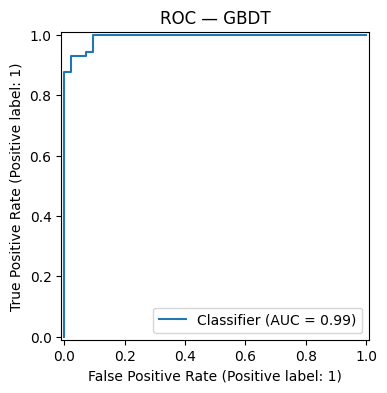

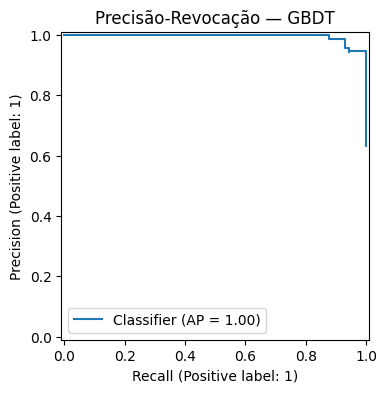

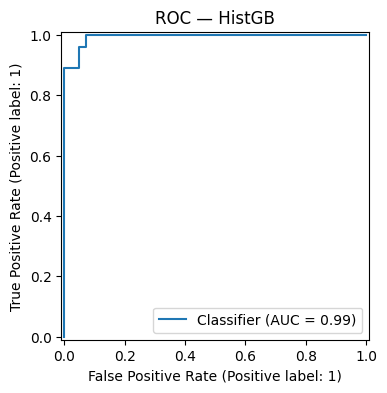

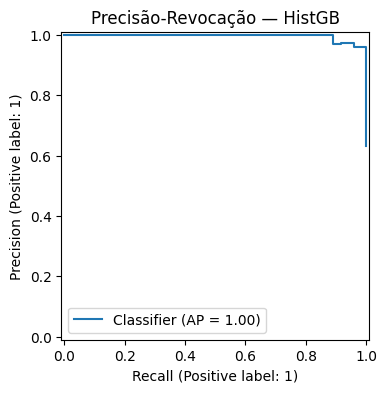

In [47]:

models_cls = {
    "Tree": (tree_cls, proba),
    "RandomForest": (rf_cls, proba_rf),
    "AdaBoost": (ada, ada.predict_proba(Xc_test)[:,1]),
    "GBDT": (gbc, gbc.predict_proba(Xc_test)[:,1]),
    "HistGB": (hgbc, hgbc.predict_proba(Xc_test)[:,1])
}

for name, (m, scores) in models_cls.items():
    RocCurveDisplay.from_predictions(yc_test, scores)
    plt.title(f"ROC — {name}")
    plt.show()
    PrecisionRecallDisplay.from_predictions(yc_test, scores)
    plt.title(f"Precisão-Revocação — {name}")
    plt.show()


## 6) Curvas de aprendizado

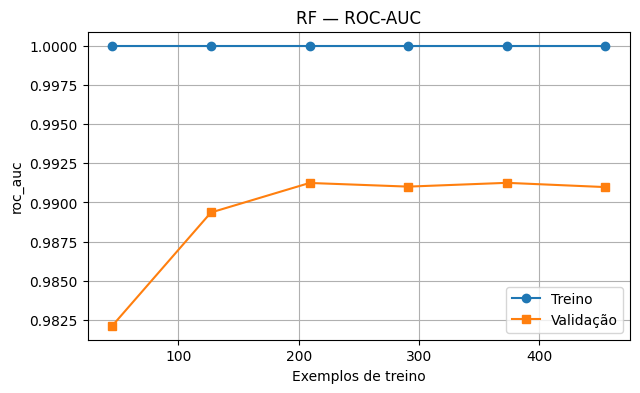

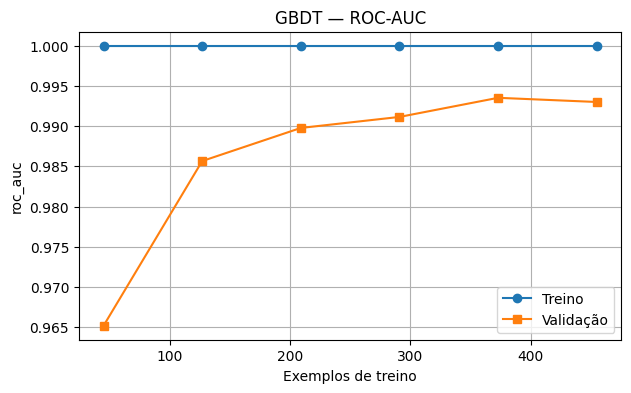

In [48]:

def plot_learning_curve(model, X, y, cv, scoring="roc_auc", title="Curva de Aprendizado"):
    sizes, train_sc, val_sc = learning_curve(model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1,1.0,6))
    plt.figure()
    plt.plot(sizes, train_sc.mean(axis=1), marker='o', label="Treino")
    plt.plot(sizes, val_sc.mean(axis=1), marker='s', label="Validação")
    plt.xlabel("Exemplos de treino"); plt.ylabel(scoring); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(rf_cls, Xc, yc, cv=cv_cls, title="RF — ROC-AUC")
plot_learning_curve(gbc, Xc, yc, cv=cv_cls, title="GBDT — ROC-AUC")


## 7) Importância de atributos (Gini vs. Entropia)

In [49]:

imp_gini = pd.Series(rf_cls.feature_importances_, index=Xc.columns).sort_values(ascending=False).head(10)
imp_gini


,0
worst perimeter,0.137541
worst radius,0.119571
worst concave points,0.106523
mean concave points,0.105097
worst area,0.102537
mean perimeter,0.056104
mean area,0.049445
mean concavity,0.045740
worst concavity,0.038972
area error,0.036145


In [50]:

rf_cls_entropy = RandomForestClassifier(n_estimators=400, max_features='sqrt', oob_score=True, random_state=7, criterion = "entropy", n_jobs=-1)
rf_cls_entropy.fit(Xc_train, yc_train)
imp_entropy = pd.Series(rf_cls_entropy.feature_importances_, index=Xc.columns).sort_values(ascending=False).head(10)
imp_entropy

,0
worst perimeter,0.137107
worst radius,0.112354
worst concave points,0.105399
worst area,0.099733
mean concave points,0.091860
mean perimeter,0.049100
worst concavity,0.046337
mean area,0.045113
mean concavity,0.044185
area error,0.035848


## 8) Dependência parcial

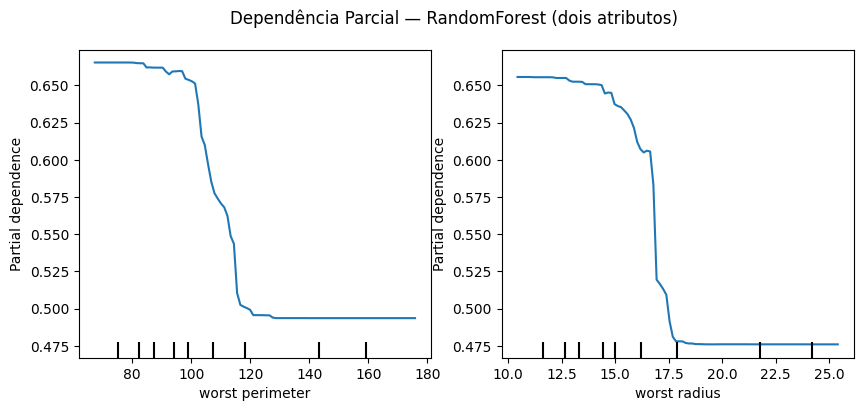

In [51]:

feat_top = list(imp_gini.index[:2])
fig, ax = plt.subplots(1, len(feat_top), figsize=(10,4))
PartialDependenceDisplay.from_estimator(rf_cls, Xc_test, features=feat_top, ax=ax)
plt.suptitle("Dependência Parcial — RandomForest (dois atributos)")
plt.show()


## 9) Avaliação para regressão

In [52]:

for name, pred in {
    "Tree": predr, "RF": pred_rf, "GBDT": pred_gbr, "HistGB": pred_hgbr
}.items():
    rmse = np.sqrt(mean_squared_error(yr_test, pred))
    r2 = r2_score(yr_test, pred)
    print(f"{name:8s} -> RMSE={rmse:.3f} | R2={r2:.3f}")


Tree     -> RMSE=0.724 | R2=0.600
RF       -> RMSE=0.493 | R2=0.814
GBDT     -> RMSE=0.509 | R2=0.802
HistGB   -> RMSE=0.450 | R2=0.846


## 10) *Mini* Tuning (GridSearchCV)

In [53]:

param = {
    "n_estimators": [100, 200, 400],
    "max_depth": [1, 2],
    "max_features": ["sqrt", "log2"]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                    param_grid=param, scoring="accuracy", cv=5, n_jobs=-1)
grid.fit(Xc_train, yc_train)
print("Melhor RF:", grid.best_params_, "ACC (CV):", round(grid.best_score_,3))
best_rf = grid.best_estimator_
test_acc = accuracy_score(yc_test, best_rf.predict(Xc_test))
print("ACC teste (melhor RF):", round(test_acc,3))


Melhor RF: {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100} ACC (CV): 0.949
ACC teste (melhor RF): 0.947
